In [40]:
!pip install pandas-plink limix-lmm

In [41]:
import numpy as np
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [42]:
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

### Preprocessing pipeline (run in shell)

BFILE=oyku/data/ALL.chr22_GRCh38.genotypes.20170504

OUTDIR=oyku/data/qc

mkdir -p "$OUTDIR"

plink --bfile "$BFILE" --snps-only --geno 0.02 --maf 0.01 --hwe 1e-6 --make-bed --out "$OUTDIR"/chr22_step1_common

plink --bfile "$OUTDIR"/chr22_step1_common --list-duplicate-vars ids-only suppress-first --out "$OUTDIR"/dupcheck

plink --bfile "$OUTDIR"/chr22_step1_common --exclude "$OUTDIR"/dupcheck.dupvar --make-bed --out "$OUTDIR"/chr22_step2_nodup

plink --bfile "$OUTDIR"/chr22_step2_nodup --mind 0.02 --make-bed --out "$OUTDIR"/chr22_step3_sampleqc

In [43]:
import os
import shutil

# Copy QC'd data to malena_v so we don't depend on oyku/data
base = os.path.dirname(os.path.abspath('.')) if os.path.basename(os.path.abspath('.')) == 'malena_v' else os.path.abspath('.')
malena_data = os.path.join(base, 'malena_v', 'data', 'qc')
source_dir = os.path.join(base, 'oyku', 'data', 'qc')
bfile_base = 'chr22_step3_sampleqc'

os.makedirs(malena_data, exist_ok=True)
for ext in ['.bed', '.bim', '.fam']:
    src = os.path.join(source_dir, bfile_base + ext)
    dst = os.path.join(malena_data, bfile_base + ext)
    if os.path.exists(src):
        shutil.copy2(src, dst)
        print(f"Copied {bfile_base}{ext}")
bfile = os.path.join(malena_data, bfile_base)
if not os.path.exists(bfile + '.bed'):
    bfile = os.path.join(source_dir, bfile_base)  # fallback

bim, fam, G = read_plink(bfile)

Copied chr22_step3_sampleqc.bed
Copied chr22_step3_sampleqc.bim
Copied chr22_step3_sampleqc.fam


Mapping files: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


In [44]:
n_snps, n_samples = bim.shape[0], fam.shape[0]
n_snps, n_samples

(59743, 2504)

In [45]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return fam, G

In [46]:
X_real = G.compute().T
mu_full = X_real.mean(axis=0)
sd_full = X_real.std(axis=0, ddof=0)
keep_full = sd_full > 1e-12
keep_idx = np.where(keep_full)[0]
standardized_X = (X_real[:, keep_full] - mu_full[keep_full]) / sd_full[keep_full]
bim_kept = bim.iloc[keep_idx].copy().reset_index(drop=True)
bim_kept['orig_bim_idx'] = keep_idx

### Phase 1: Phenotype Simulation

In [47]:
M, h2 = 10, 0.1
np.random.seed(42)
idx_caus = np.random.choice(standardized_X.shape[1], size=M)
var_expl = np.repeat(h2/M, M)

In [48]:
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    assert len(idx_caus) == len(var_expl)
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
    ve = 1 - var_expl.sum()
    assert ve > 0
    beta = np.sqrt(var_expl) * direction
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)
    yg = Xc.dot(beta)[:, None]
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)
    y = yg + yn
    beta_real = np.zeros(X.shape[1])
    beta_real[idx_caus] = beta
    ystd = y.std()
    y = (y - y.mean()) / ystd
    beta_real = beta_real / ystd
    return y, beta_real

y, beta_real = simulate_pheno(standardized_X, idx_caus, var_expl)

### Phase 2: GWAS / Feature Selection

#### 1. Training/Validation Set Split

In [49]:
from sklearn.model_selection import train_test_split

n_samples = len(standardized_X)
indices = np.arange(n_samples)
train_idx, val_idx = train_test_split(indices, test_size=0.30, random_state=42)

X_train = standardized_X[train_idx]
X_val = standardized_X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]
fam_train = fam.iloc[train_idx].copy()
fam_val = fam.iloc[val_idx].copy()
X_test, y_test = X_val, y_val

#### 2. GWAS (training set only)

In [50]:
F = np.ones_like(y_train)
lmm = LMM(y_train, F)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

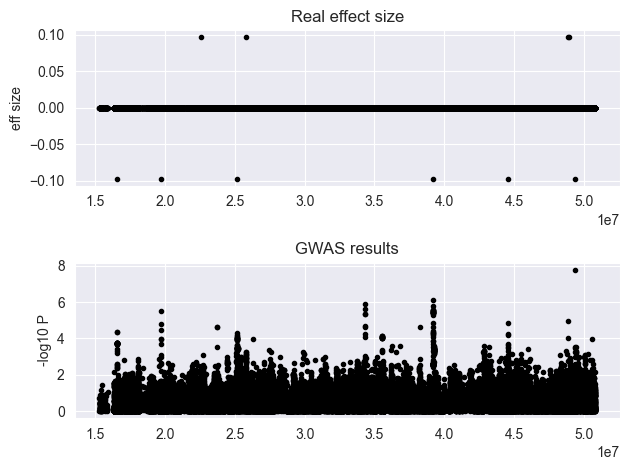

In [51]:
x = bim_kept['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log10 P')
plt.tight_layout()
plt.show()

#### 3. PLINK Clumping (LD-based, training set only)

Leakage prevention: LD and SNP selection from training only.

In [52]:
outdir = 'plink_output'
os.makedirs(outdir, exist_ok=True)
fam_train[['fid', 'iid']].to_csv(os.path.join(outdir, 'train_keep.txt'), sep='\t', index=False, header=False)
fam_val[['fid', 'iid']].to_csv(os.path.join(outdir, 'val_keep.txt'), sep='\t', index=False, header=False)

!plink --bfile {bfile} --keep {outdir}/train_keep.txt --make-bed --out {outdir}/train_set --allow-no-sex
!plink --bfile {bfile} --keep {outdir}/val_keep.txt --make-bed --out {outdir}/val_set --allow-no-sex

PLINK v1.90p 64-bit (6 Sep 2023)               www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_output/train_set.log.
Options in effect:
  --allow-no-sex
  --bfile /Users/malenavoss/GoBi_Theis/GWAS Blockteil/gobi_gwas/malena_v/data/qc/chr22_step3_sampleqc
  --keep plink_output/train_keep.txt
  --make-bed
  --out plink_output/train_set

Error: --bfile accepts at most 1 parameter.
For more information, try "plink --help <flag name>" or "plink --help | more".
PLINK v1.90p 64-bit (6 Sep 2023)               www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_output/val_set.log.
Options in effect:
  --allow-no-sex
  --bfile /Users/malenavoss/GoBi_Theis/GWAS Blockteil/gobi_gwas/malena_v/data/qc/chr22_step3_sampleqc
  --keep plink_output/val_keep.txt
  --make-bed
  --out plink_output/val_set

Error: --bfile accepts at most 1 parameter.
For m

In [53]:
pv_safe = np.clip(pv, 1e-300, 1.0)
gwas_summary = pd.DataFrame({'CHR': bim_kept['chrom'].astype(int), 'SNP': bim_kept['snp'], 'BP': bim_kept['pos'].astype(int), 'P': pv_safe})
gwas_summary.to_csv(os.path.join(outdir, 'gwas_train.sumstats'), sep='\t', index=False)

!plink --bfile {outdir}/train_set --clump {outdir}/gwas_train.sumstats --clump-p1 0.05 --clump-p2 0.05 --clump-r2 0.2 --clump-kb 250 --out {outdir}/clumped --allow-no-sex

PLINK v1.90p 64-bit (6 Sep 2023)               www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_output/clumped.log.
Options in effect:
  --allow-no-sex
  --bfile plink_output/train_set
  --clump plink_output/gwas_train.sumstats
  --clump-kb 250
  --clump-p1 0.05
  --clump-p2 0.05
  --clump-r2 0.2
  --out plink_output/clumped

16384 MB RAM detected; reserving 8192 MB for main workspace.
Error: Failed to open plink_output/train_set.bed.


In [54]:
clump_file = os.path.join(outdir, 'clumped.clumped')
if os.path.exists(clump_file):
    clumped = pd.read_csv(clump_file, sep=r'\s+')
    snp_clumped = set(clumped['SNP'].values) if len(clumped) > 0 else set(bim_kept['snp'])
else:
    snp_clumped = set(bim_kept['snp'])

clump_mask = bim_kept['snp'].isin(snp_clumped).values
X_train_clumped = X_train[:, clump_mask]
X_val_clumped = X_val[:, clump_mask]
bim_clumped = bim_kept.loc[clump_mask].reset_index(drop=True)
print(f"Clumping retained {len(snp_clumped)} SNPs")

Clumping retained 59740 SNPs


### Phase 3: Model Development

In [55]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

y_train_flat = np.ravel(y_train)
y_val_flat = np.ravel(y_val)

def evaluate_model(y_true, y_pred, name=""):
    return {"model": name, "R2": r2_score(y_true, y_pred), "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))}

In [57]:
# 1. PRS (GWAS weights)
beta_clumped = beta[clump_mask].flatten()
prs_train = X_train_clumped @ beta_clumped
prs_val = X_val_clumped @ beta_clumped
prs_fit = LinearRegression().fit(prs_train.reshape(-1, 1), y_train_flat)
prs_val_cal = prs_fit.predict(prs_val.reshape(-1, 1))
results = [evaluate_model(y_val_flat, prs_val_cal, "PRS (GWAS weights)")]
print(f"PRS — R²: {results[-1]['R2']:.4f}")

PRS — R²: -0.1062


In [58]:
# 2. OLS
ols = LinearRegression().fit(X_train_clumped, y_train_flat)
results.append(evaluate_model(y_val_flat, ols.predict(X_val_clumped), "OLS"))



In [ ]:
# 4. Lasso (CV on training)
lasso_cv = GridSearchCV(Lasso(), param_grid={"alpha": np.logspace(-5, 1, 13)}, cv=5, scoring="r2")
lasso_cv.fit(X_train_clumped, y_train_flat)
results.append(evaluate_model(y_val_flat, lasso_cv.best_estimator_.predict(X_val_clumped), "Lasso (CV)"))



/Users/malenavoss/GoBi_Theis/GWAS Blockteil/gobi_gwas/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.662e-01, tolerance: 1.404e-01
  model = cd_fast.enet_coordinate_descent(
/Users/malenavoss/GoBi_Theis/GWAS Blockteil/gobi_gwas/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.979e-01, tolerance: 1.451e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
results_df = pd.DataFrame(results)
results_df

plt.figure(figsize=(8, 4))
plt.barh(results_df['model'], results_df['R2'], color='steelblue', alpha=0.8)
plt.xlabel('Validation R²')
plt.title('Model comparison')
plt.axvline(0, color='gray', ls='--')
plt.tight_layout()
plt.show()